In [1]:
!pip install kaggle
!mkdir /root/.kaggle
!echo '{"username":"roknbae","key":"7e6c29161d21e99c37b20df1e006950a"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
import kaggle
kaggle.api.dataset_download_files('alexandrepetit881234/fake-bills', path='fake_bills', unzip=True)


Dataset URL: https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills


In [3]:
import pandas as pd
df = pd.read_csv('fake_bills/fake_bills.csv', sep=';')

In [4]:
df['is_genuine'] = df['is_genuine'].astype(int)
df = pd.get_dummies(df, columns=['is_genuine'], prefix='is_genuine')

<Axes: >

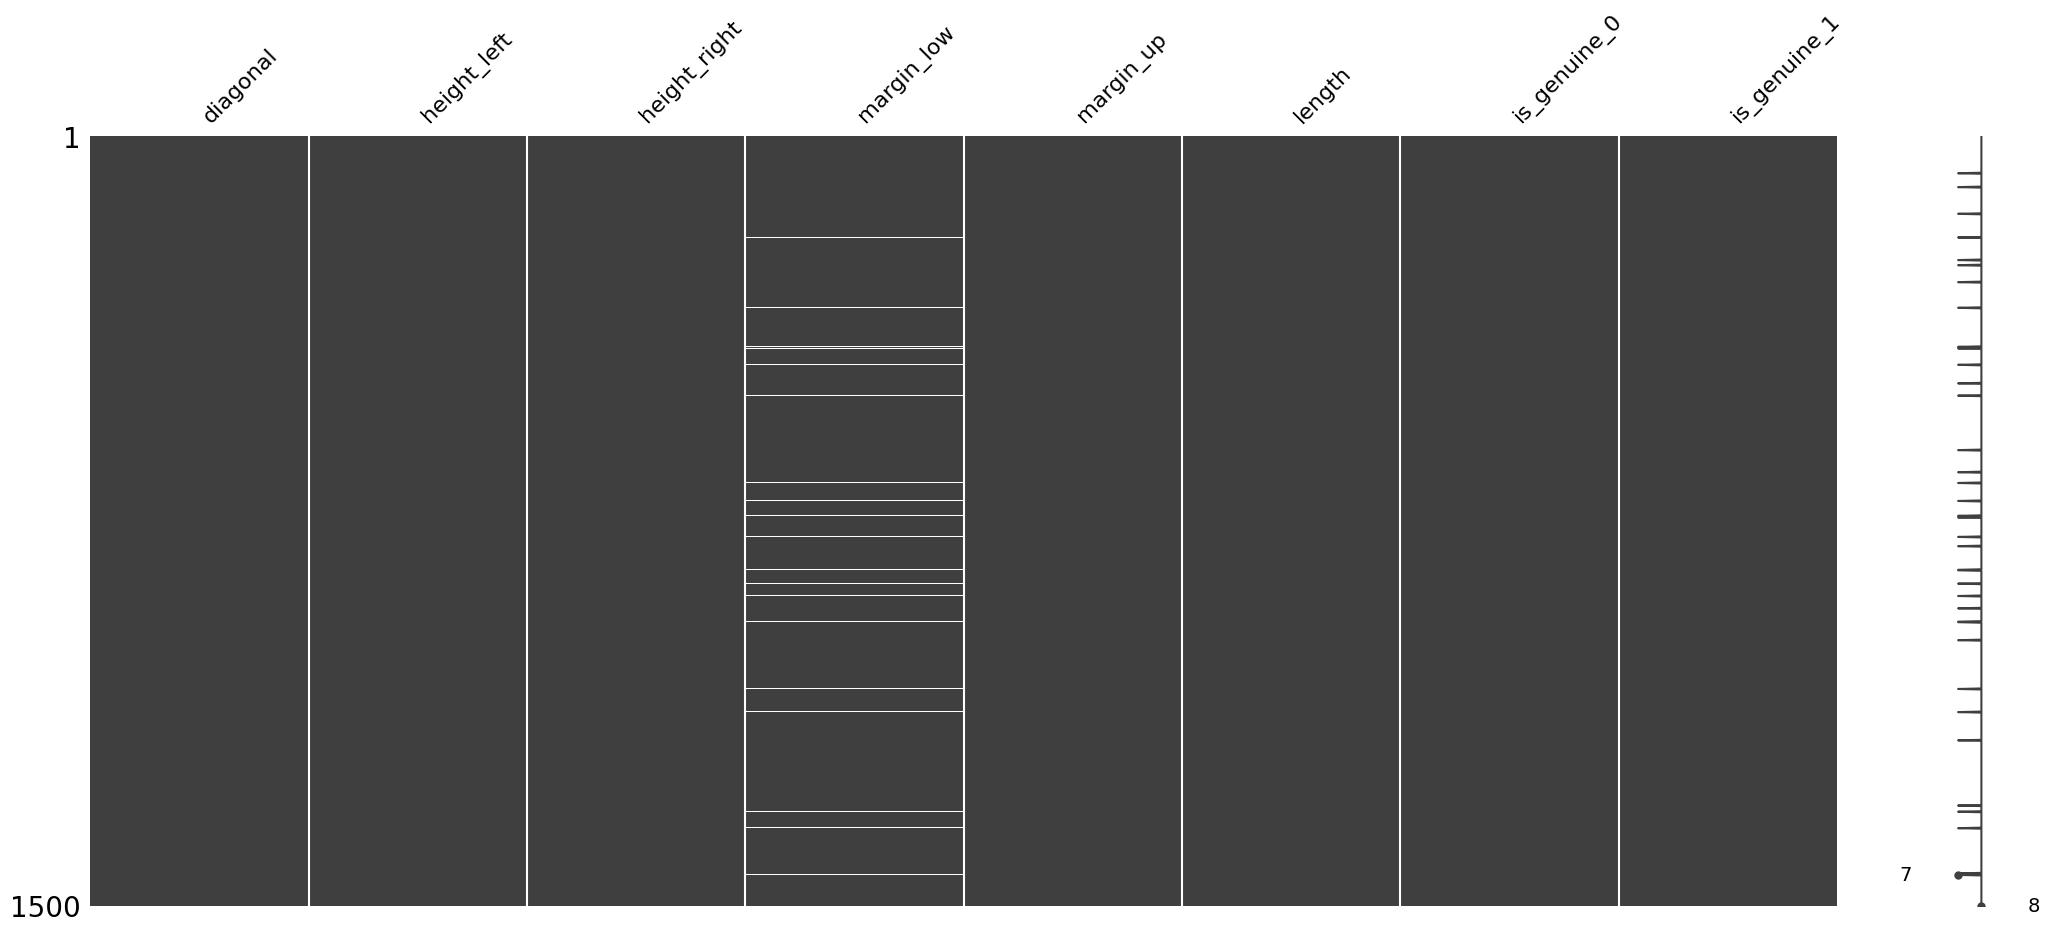

In [5]:
import missingno as msno
msno.matrix(df)

<Axes: >

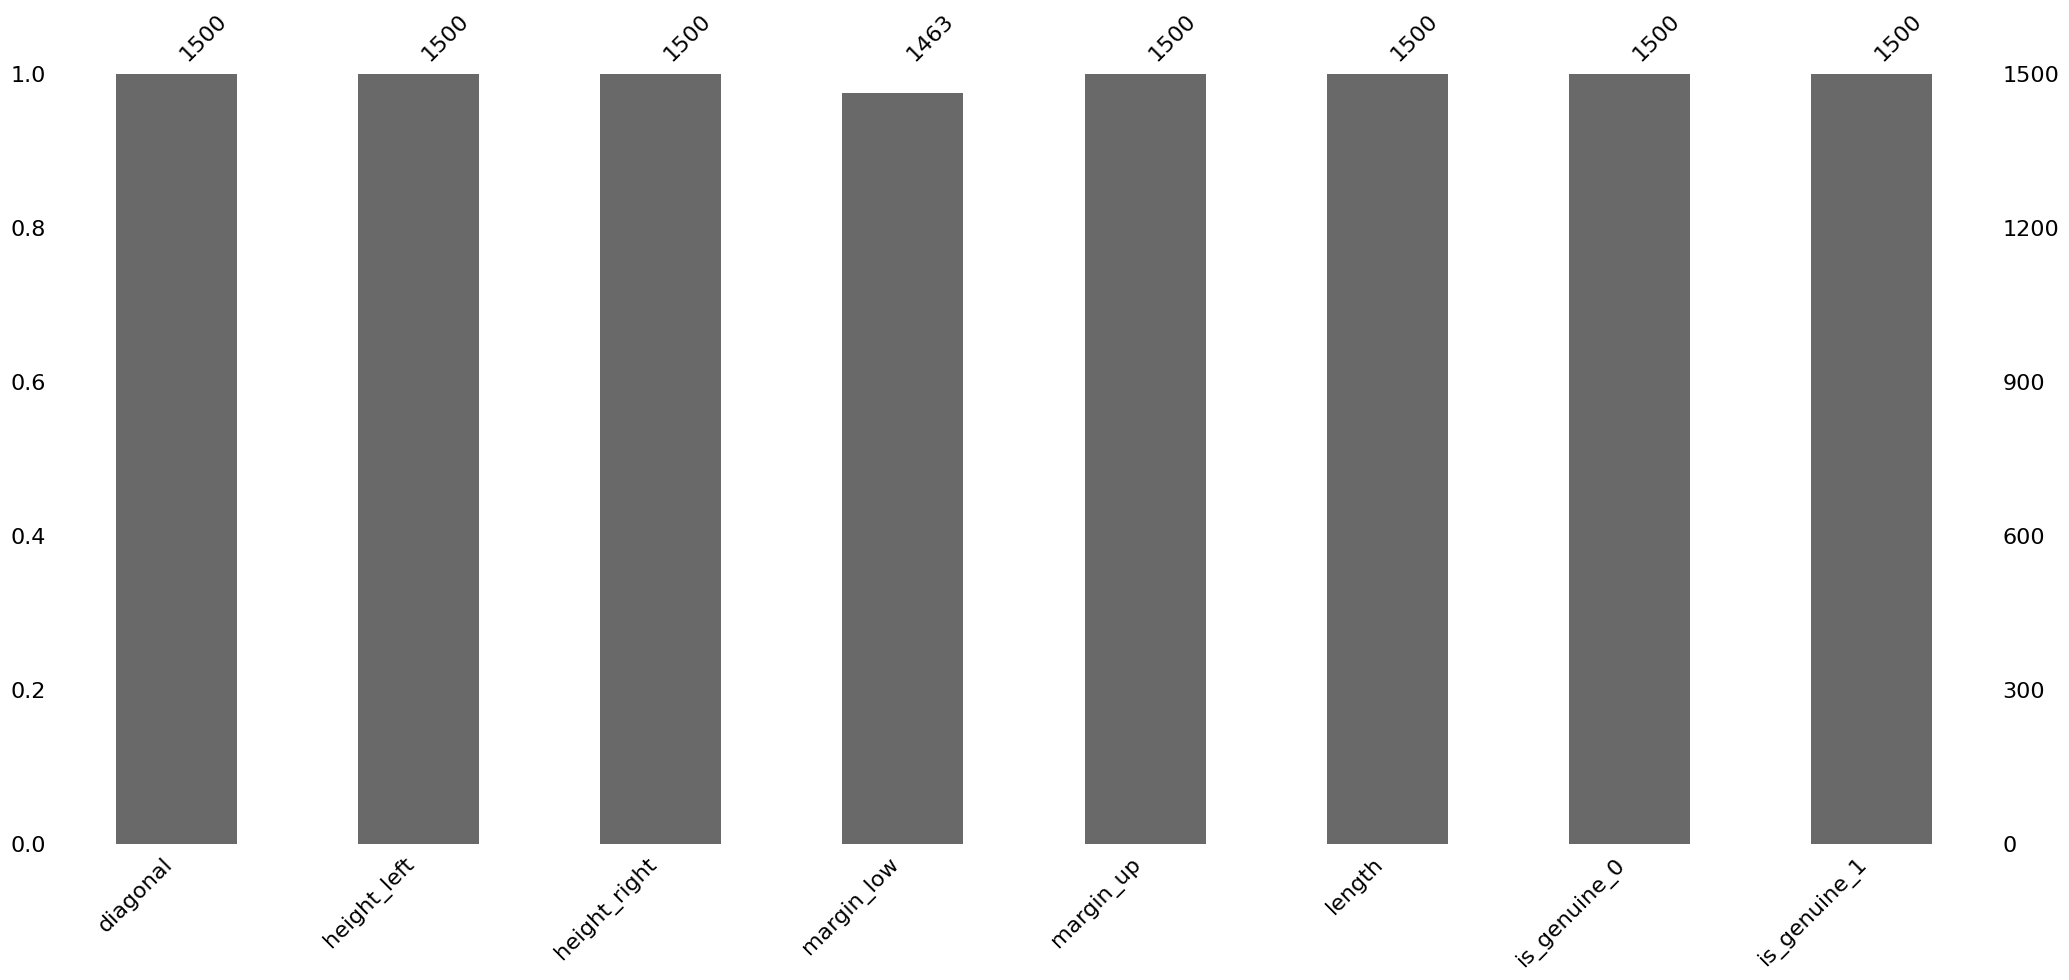

In [6]:
msno.bar(df)

In [7]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df)
df = pd.DataFrame(df_imputed, columns=df.columns)

In [8]:
print(df.isnull().sum())

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
is_genuine_0    0
is_genuine_1    0
dtype: int64


<Axes: >

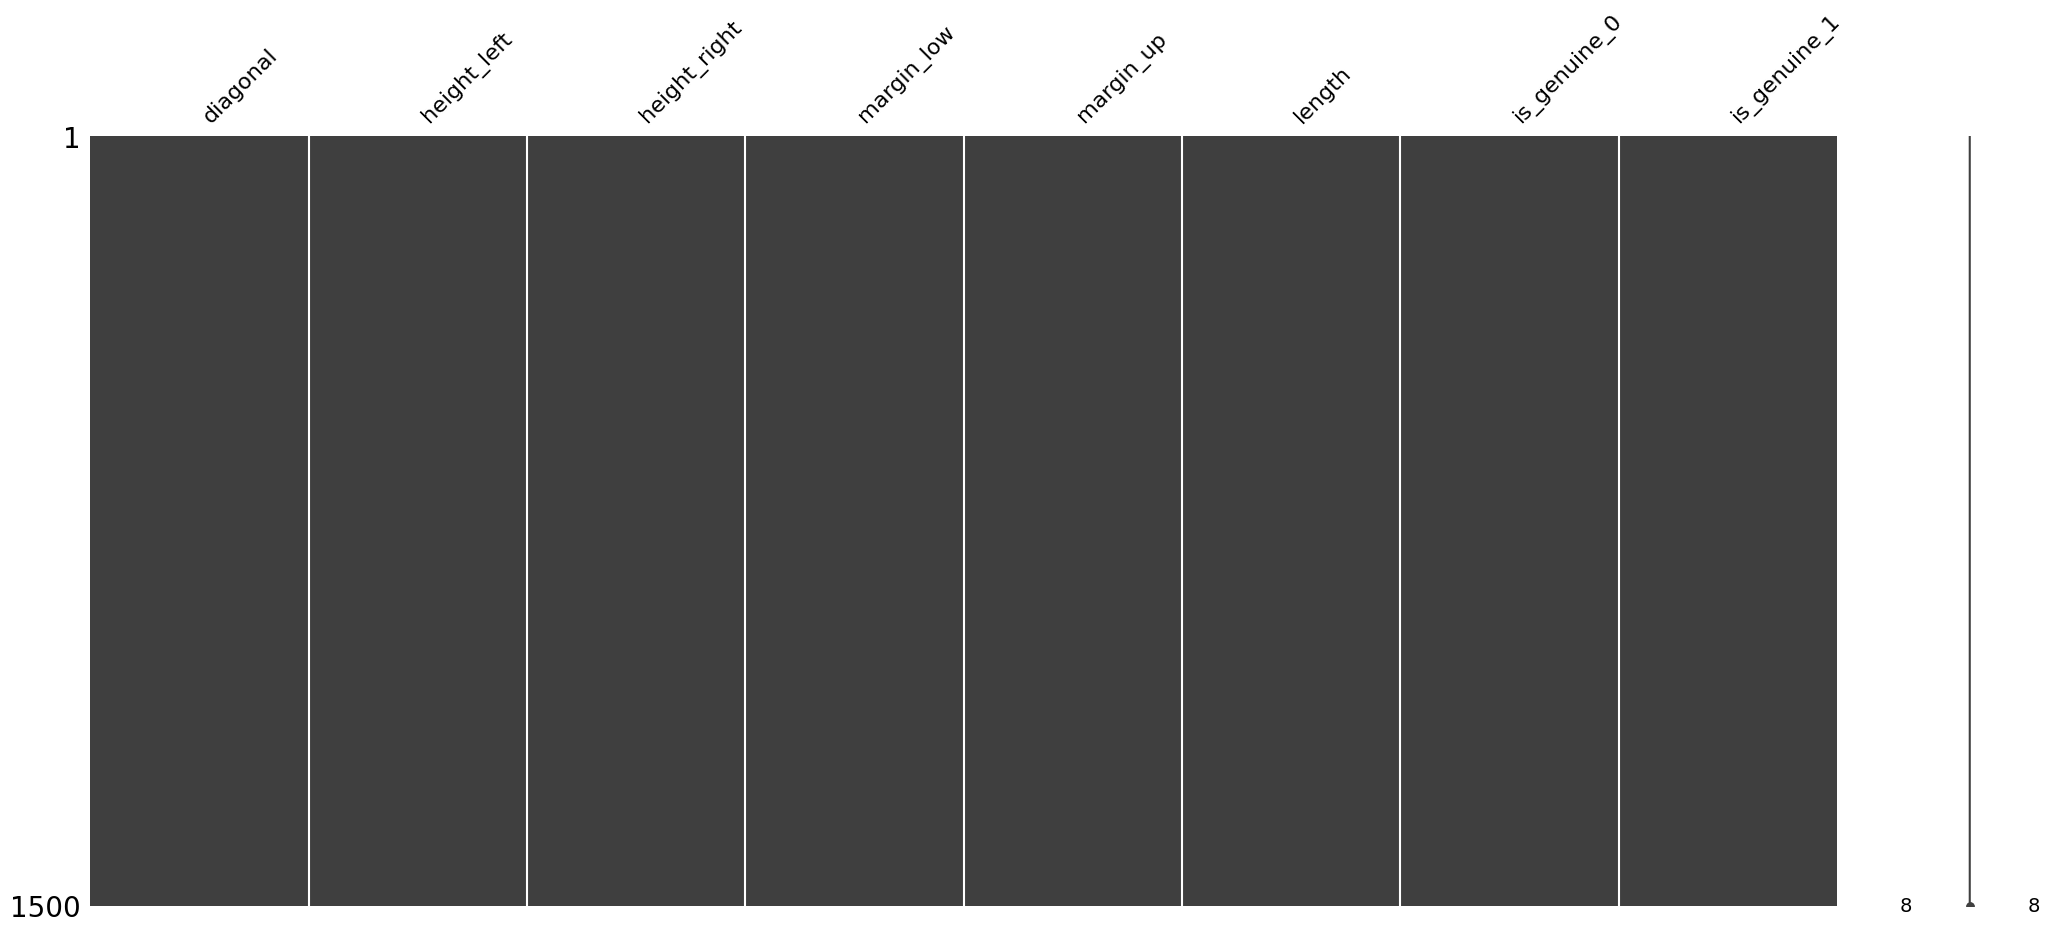

In [9]:
msno.matrix(df)

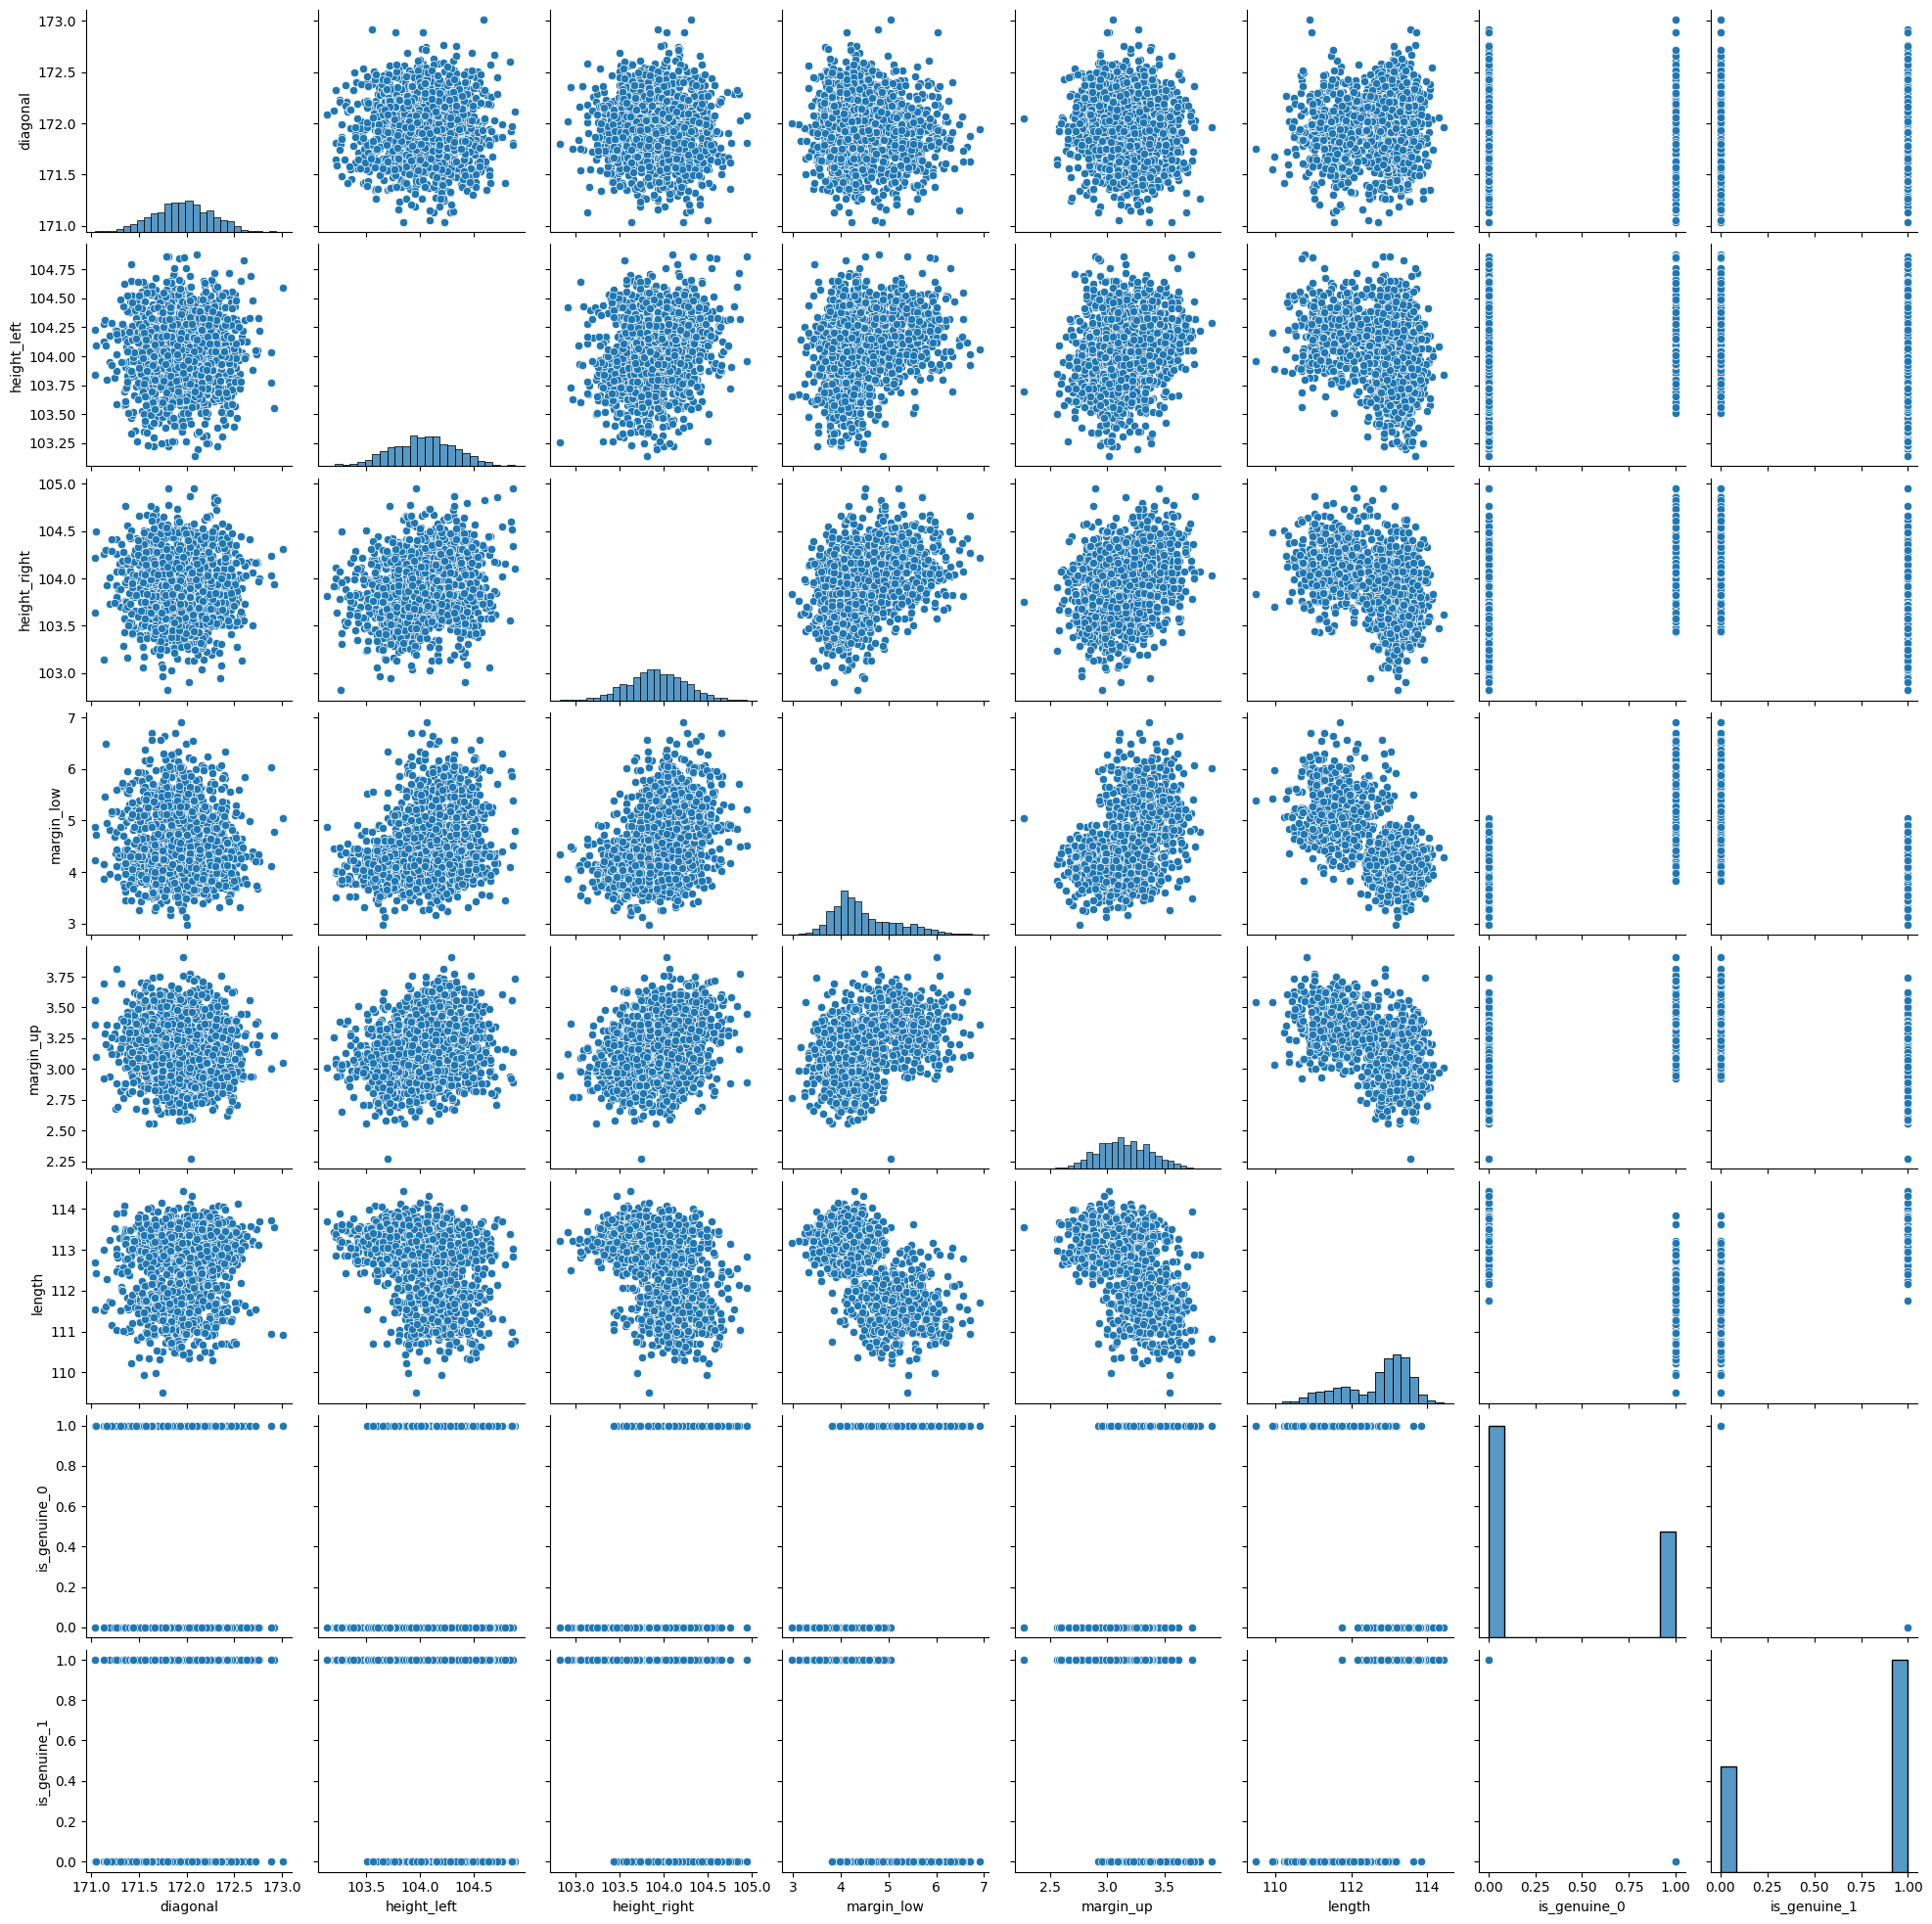

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df)
plt.show()

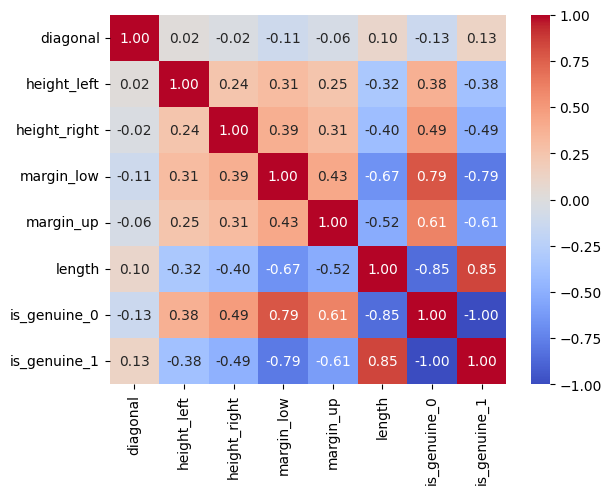

In [11]:
import numpy as np
corr_matrix = np.corrcoef(df, rowvar=False)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=df.columns, yticklabels=df.columns)
plt.show()


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = [col for col in df.columns if col not in ['is_genuine_0', 'is_genuine_1']]
df_standardized = scaler.fit_transform(df[columns_to_scale])
df_scaled = pd.DataFrame(df_standardized, columns=columns_to_scale)
df_final = pd.concat([df[['is_genuine_0', 'is_genuine_1']], df_scaled], axis=1)
df = pd.DataFrame(df_final, columns=df.columns)


In [14]:
df.drop(['is_genuine_0'], axis=1, inplace=True)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('is_genuine_1', axis=1), df['is_genuine_1'], test_size=0.2, stratify=df['is_genuine_1'], random_state=42)


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [18]:
best_knn = grid_search.best_estimator_
test_score = best_knn.score(X_test, y_test)
print("Test score with optimal hyperparameters:", test_score)

Test score with optimal hyperparameters: 0.99


In [19]:
best_params = grid_search.best_params_
knn_optimal = KNeighborsClassifier(**best_params)
knn_optimal.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [20]:
test_score = knn_optimal.score(X_test, y_test)
print("Test score with optimal hyperparameters:", test_score)

Test score with optimal hyperparameters: 0.99
